# 05 - EDA y Modelado: Forecast de Series Temporales

## Descripción del Dataset
Dataset especializado **100% en series de tiempo** agregado a nivel departamental (Santander) con:
- **190 meses** de datos (2010-2025)
- **16 variables**: fecha, delitos, lags, rolling windows, estacionalidad

## Objetivo del Notebook
Construir un modelo de **forecast de series temporales** para predecir la evolución mensual de delitos.

## Modelos a Explorar
| Modelo | Descripción |
|--------|-------------|
| **Prophet** | Modelo de Facebook para series con estacionalidad y tendencia |
| **ARIMA/SARIMA** | Modelos clásicos autoregresivos |
| **XGBoost Temporal** | Regresión con features de lag |

## Preguntas que Responde
- ¿Cómo evolucionarán los delitos mes a mes?
- ¿Existen patrones estacionales fuertes?
- ¿Cuál es la tendencia general (creciente/decreciente)?
- ¿Cuántos delitos habrá en los próximos N meses?

## Utilidad Práctica
- **Forecast robusto** orientado al tiempo
- **Planificación de recursos** a mediano plazo
- **Detección de anomalías** cuando los valores reales difieren del forecast

## Contenido del Notebook
1. Exploración inicial y análisis de la serie
2. Descomposición de la serie (tendencia, estacionalidad, residuos)
3. Preprocesamiento para modelado
4. Modelado con Prophet
5. Evaluación del modelo
6. Forecast futuro
7. Guardado del modelo

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_timeseries_dataset.parquet'

In [7]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head(10)

Shape: (190, 16)

Columnas: ['anio_mes', 'total_delitos', 'poblacion_total', 'fecha', 'tasa_global', 'lag_1', 'lag_3', 'lag_12', 'roll_mean_3', 'roll_mean_12', 'pct_change_1', 'pct_change_12', 'anio', 'mes', 'mes_sin', 'mes_cos']


,anio_mes,total_delitos,poblacion_total,fecha,tasa_global,lag_1,lag_3,lag_12,roll_mean_3,roll_mean_12,pct_change_1,pct_change_12,anio,mes,mes_sin,mes_cos
0,2010-01,2023.0,3880124,2010-01-01,52.137509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,1,5.000000e-01,8.660254e-01
1,2010-02,1599.0,3918510,2010-02-01,40.806327,2023.0,NaN,NaN,NaN,NaN,-0.209590,NaN,2010,2,8.660254e-01,5.000000e-01
2,2010-03,1773.0,3904562,2010-03-01,45.408422,1599.0,NaN,NaN,1798.333333,NaN,0.108818,NaN,2010,3,1.000000e+00,6.123234e-17
3,2010-04,1961.0,3861520,2010-04-01,50.783111,1773.0,2023.0,NaN,1777.666667,NaN,0.106035,NaN,2010,4,8.660254e-01,-5.000000e-01
4,2010-05,1901.0,3912430,2010-05-01,48.588729,1961.0,1599.0,NaN,1878.333333,NaN,-0.030597,NaN,2010,5,5.000000e-01,-8.660254e-01
5,2010-06,1712.0,3825912,2010-06-01,44.747501,1901.0,1773.0,NaN,1858.000000,NaN,-0.099421,NaN,2010,6,1.224647e-16,-1.000000e+00
6,2010-07,1813.0,3806326,2010-07-01,47.631233,1712.0,1961.0,NaN,1808.666667,NaN,0.058995,NaN,2010,7,-5.000000e-01,-8.660254e-01
7,2010-08,1892.0,3886504,2010-08-01,48.681283,1813.0,1901.0,NaN,1805.666667,NaN,0.043574,NaN,2010,8,-8.660254e-01,-5.000000e-01
8,2010-09,1996.0,3837900,2010-09-01,52.007608,1892.0,1712.0,NaN,1900.333333,NaN,0.054968,NaN,2010,9,-1.000000e+00,-1.836970e-16
9,2010-10,1960.0,3865708,2010-10-01,50.702226,1996.0,1813.0,NaN,1949.333333,NaN,-0.018036,NaN,2010,10,-8.660254e-01,5.000000e-01


In [8]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal meses: {len(df)}")

if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
    print(f"Período: {df['fecha'].min()} a {df['fecha'].max()}")
elif 'anio_mes' in df.columns:
    print(f"Período: {df['anio_mes'].min()} a {df['anio_mes'].max()}")

print(f"\nEstadísticas del target:")
print(df['total_delitos'].describe())

INFO GENERAL

Total meses: 190
Período: 2010-01-01 00:00:00 a 2025-10-01 00:00:00

Estadísticas del target:
count     190.000000
mean     2491.963158
std       419.411333
min      1072.000000
25%      2212.000000
50%      2526.000000
75%      2810.250000
max      3241.000000
Name: total_delitos, dtype: float64


---
## 2. Visualización de la Serie Temporal

VISUALIZACIÓN DE LA SERIE TEMPORAL


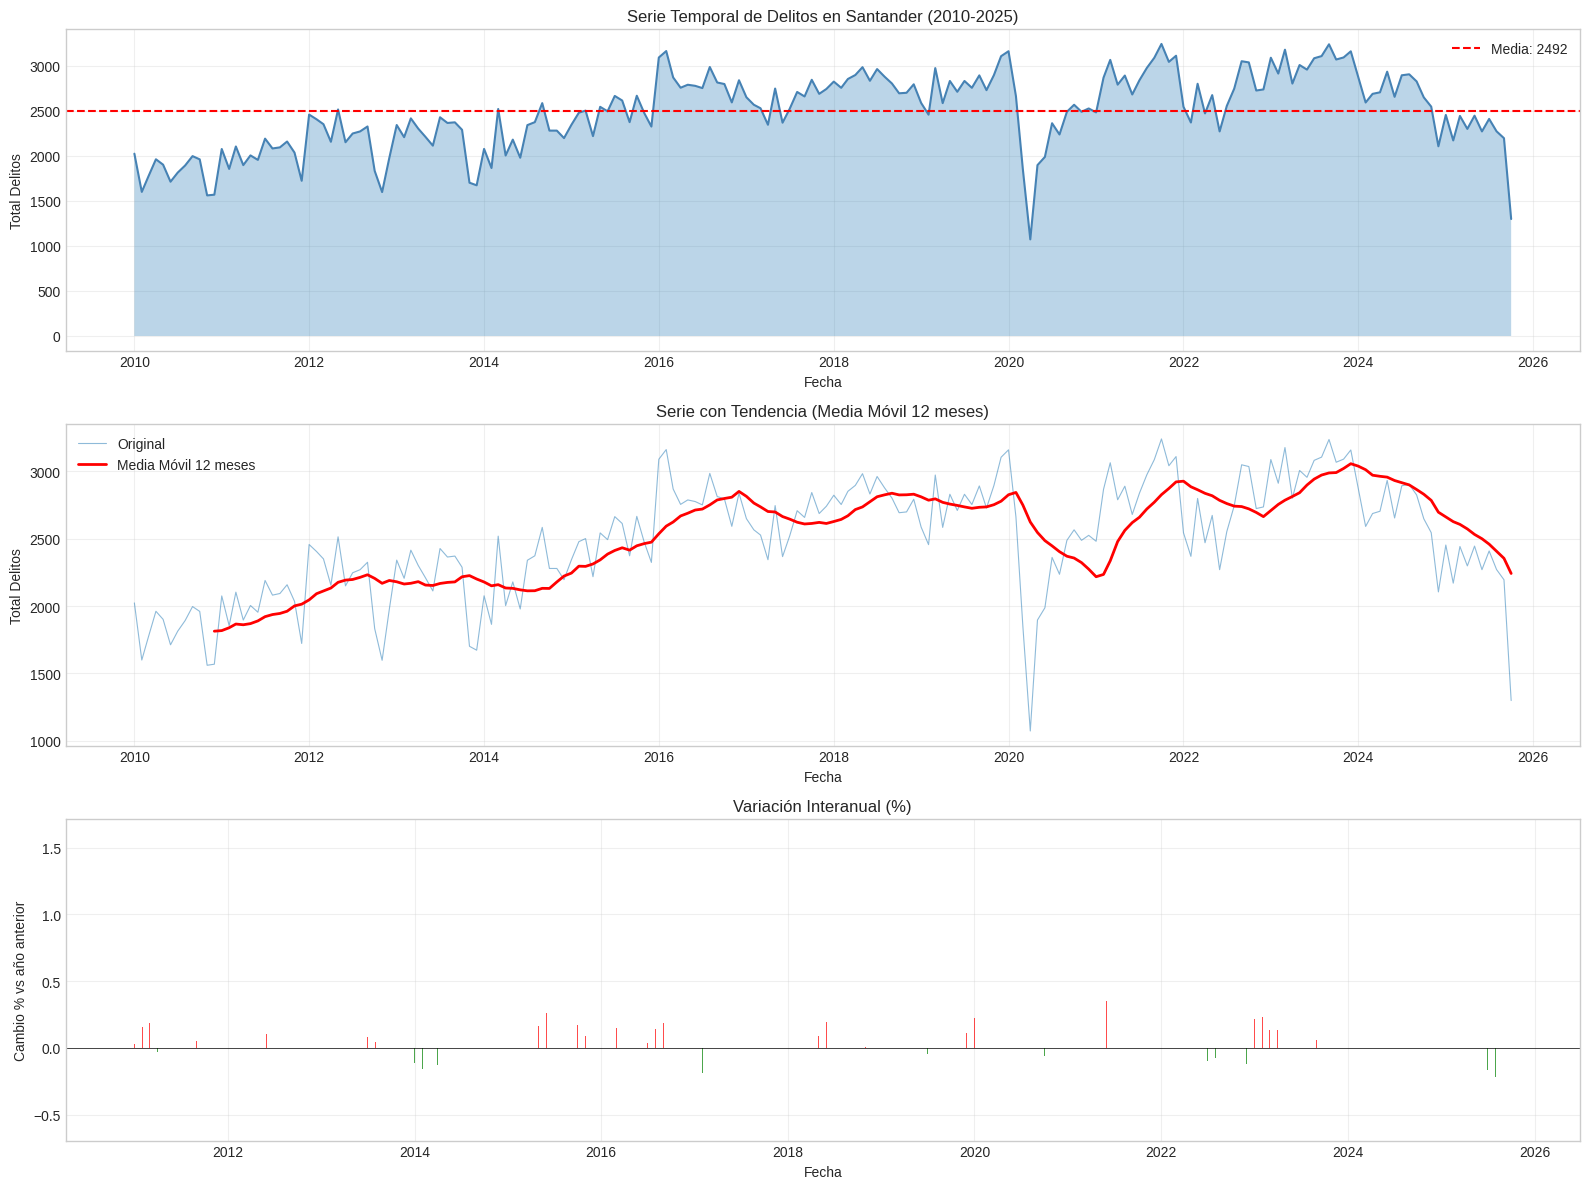

In [9]:
# 2.1 Visualización de la serie temporal completa
print("=" * 60)
print("VISUALIZACIÓN DE LA SERIE TEMPORAL")
print("=" * 60)

# Asegurar que fecha sea datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha').reset_index(drop=True)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Serie temporal completa
ax1 = axes[0]
ax1.plot(df['fecha'], df['total_delitos'], linewidth=1.5, color='steelblue')
ax1.fill_between(df['fecha'], df['total_delitos'], alpha=0.3)
ax1.axhline(df['total_delitos'].mean(), color='red', linestyle='--', label=f'Media: {df["total_delitos"].mean():.0f}')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Total Delitos')
ax1.set_title('Serie Temporal de Delitos en Santander (2010-2025)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Media móvil
ax2 = axes[1]
ax2.plot(df['fecha'], df['total_delitos'], linewidth=0.8, alpha=0.5, label='Original')
ax2.plot(df['fecha'], df['roll_mean_12'], linewidth=2, color='red', label='Media Móvil 12 meses')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Total Delitos')
ax2.set_title('Serie con Tendencia (Media Móvil 12 meses)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cambio porcentual año a año
ax3 = axes[2]
ax3.bar(df['fecha'], df['pct_change_12'], color=['green' if x < 0 else 'red' for x in df['pct_change_12'].fillna(0)], alpha=0.7)
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Cambio % vs año anterior')
ax3.set_title('Variación Interanual (%)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANÁLISIS DE ESTACIONALIDAD


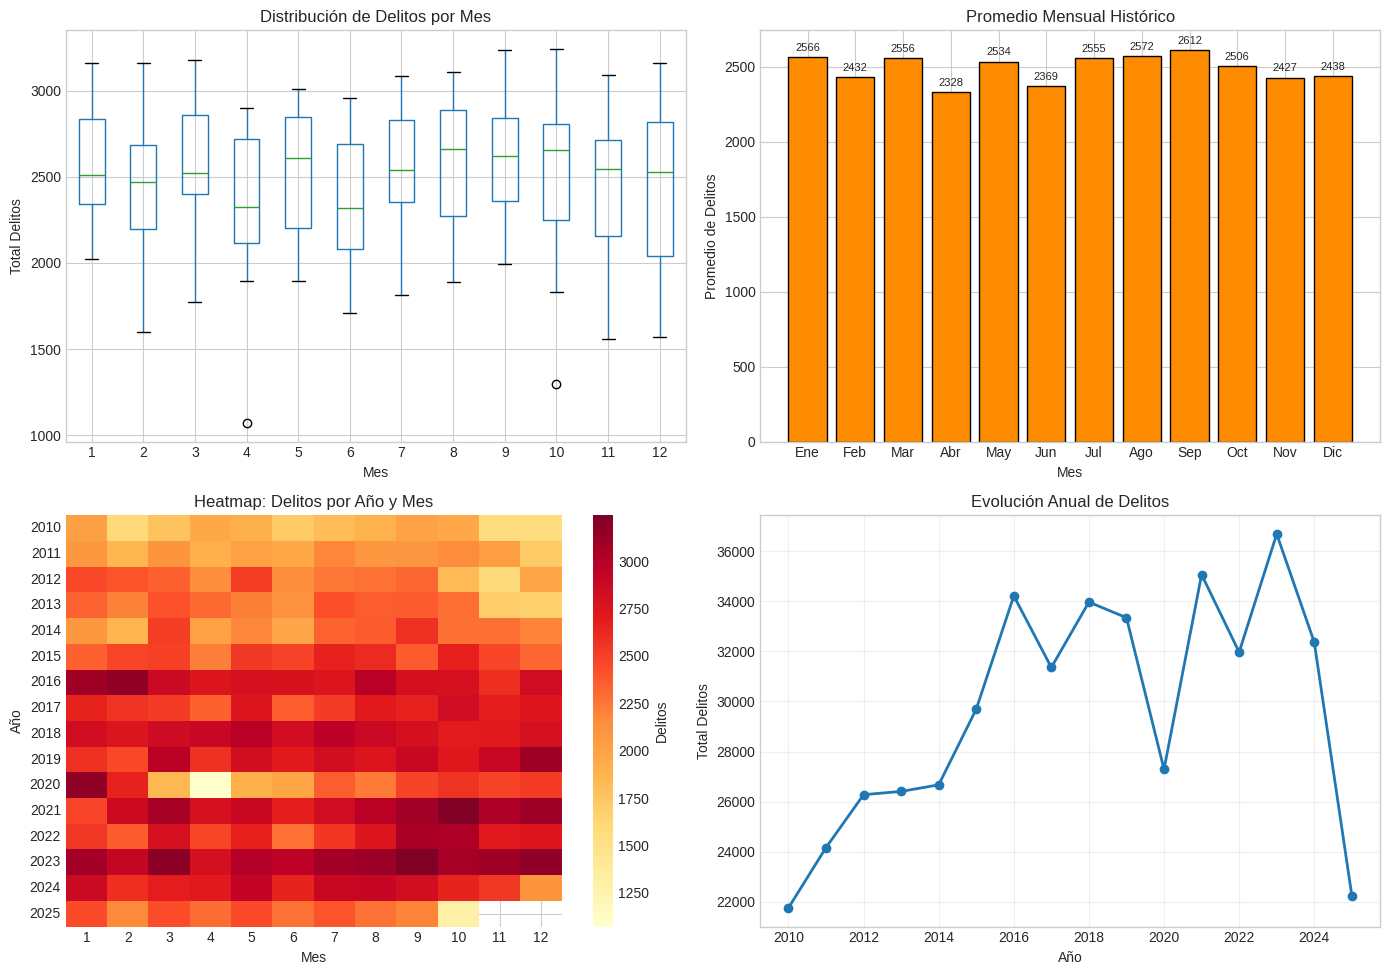


📊 Mes con MÁS delitos: 9 (2612 promedio)
📊 Mes con MENOS delitos: 4 (2328 promedio)
📊 Variación estacional: 12.2%


In [10]:
# 2.2 Análisis de estacionalidad
print("=" * 60)
print("ANÁLISIS DE ESTACIONALIDAD")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot por mes
ax1 = axes[0, 0]
df.boxplot(column='total_delitos', by='mes', ax=ax1)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Total Delitos')
ax1.set_title('Distribución de Delitos por Mes')
plt.suptitle('')

# Promedio por mes
ax2 = axes[0, 1]
promedio_mes = df.groupby('mes')['total_delitos'].mean()
bars = ax2.bar(promedio_mes.index, promedio_mes.values, color='darkorange', edgecolor='black')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Promedio de Delitos')
ax2.set_title('Promedio Mensual Histórico')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax2.bar_label(bars, fmt='%.0f', padding=3, fontsize=8)

# Heatmap año vs mes
ax3 = axes[1, 0]
pivot = df.pivot_table(values='total_delitos', index='anio', columns='mes', aggfunc='sum')
sns.heatmap(pivot, cmap='YlOrRd', annot=False, ax=ax3, cbar_kws={'label': 'Delitos'})
ax3.set_xlabel('Mes')
ax3.set_ylabel('Año')
ax3.set_title('Heatmap: Delitos por Año y Mes')

# Tendencia anual
ax4 = axes[1, 1]
total_anual = df.groupby('anio')['total_delitos'].sum()
ax4.plot(total_anual.index, total_anual.values, marker='o', linewidth=2, markersize=6)
ax4.set_xlabel('Año')
ax4.set_ylabel('Total Delitos')
ax4.set_title('Evolución Anual de Delitos')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de estacionalidad
print("\n Mes con MÁS delitos:", promedio_mes.idxmax(), f"({promedio_mes.max():.0f} promedio)")
print(" Mes con MENOS delitos:", promedio_mes.idxmin(), f"({promedio_mes.min():.0f} promedio)")
print(f" Variación estacional: {(promedio_mes.max() - promedio_mes.min()) / promedio_mes.min() * 100:.1f}%")

---
## 3. Descomposición de la Serie Temporal

DESCOMPOSICIÓN DE LA SERIE TEMPORAL


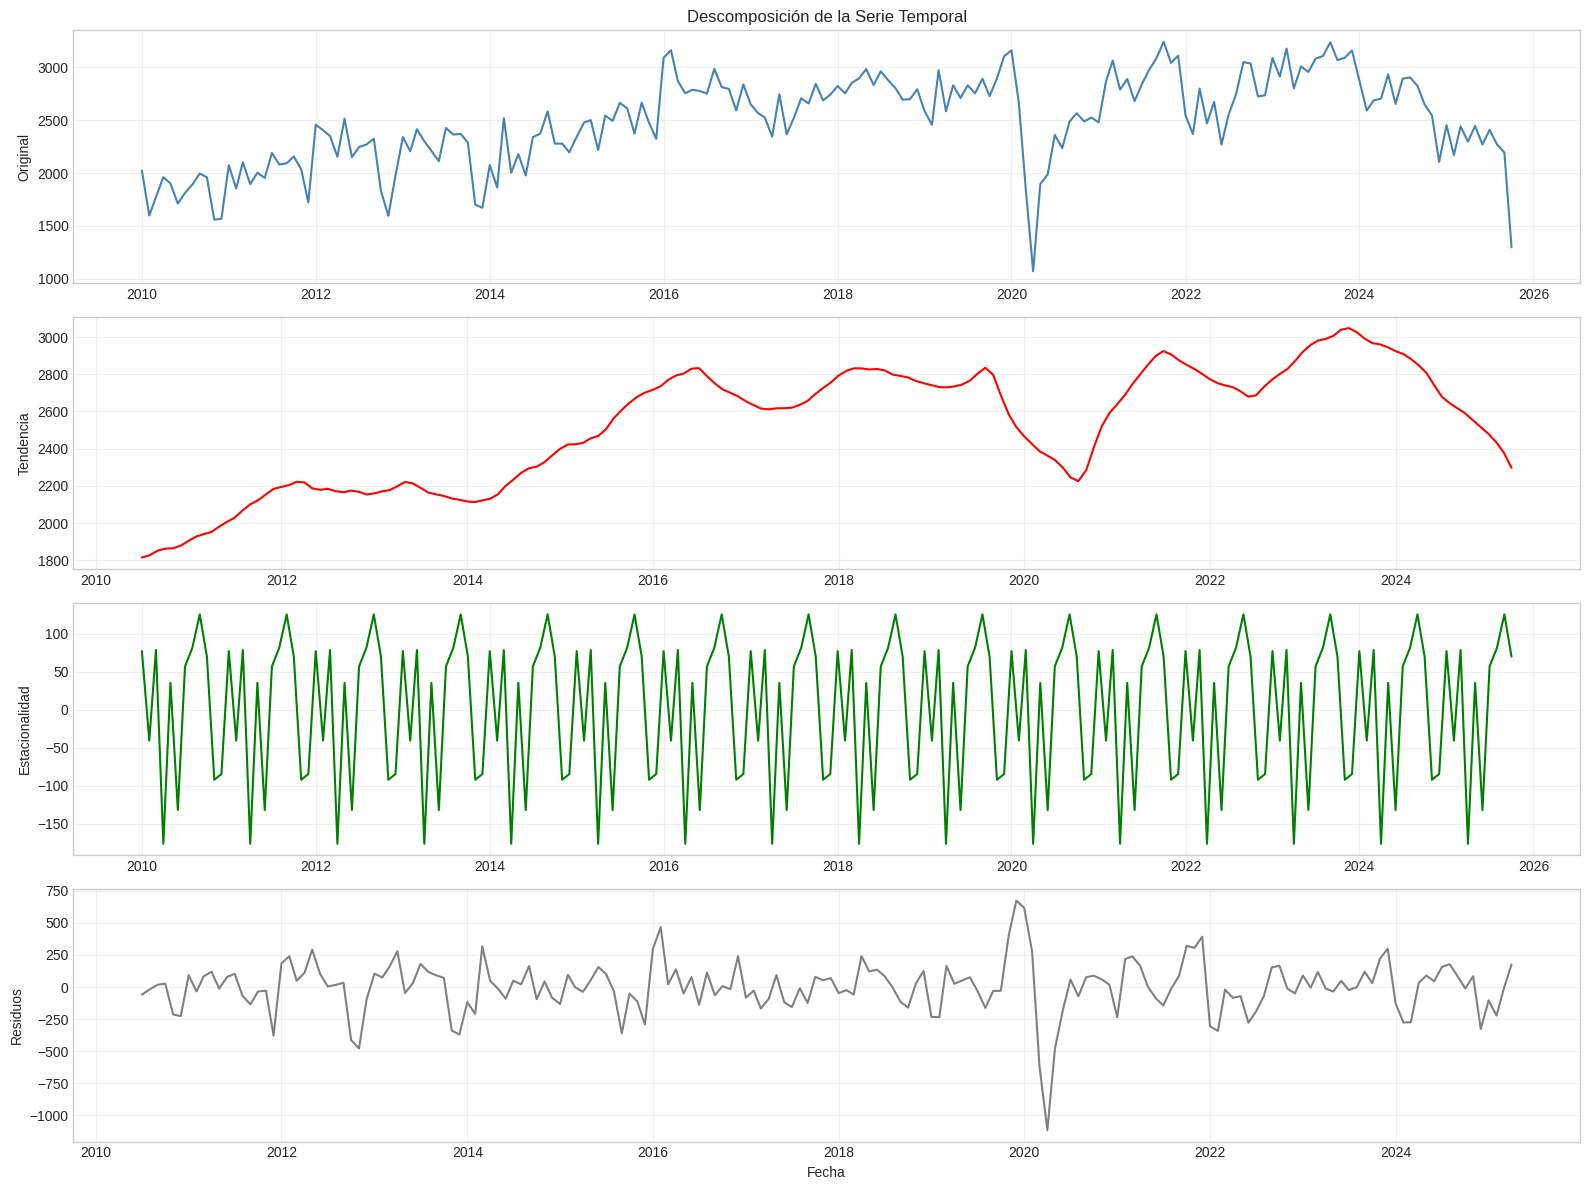


📊 Análisis de Componentes:
   Tendencia - Rango: 1815 a 3048
   Estacionalidad - Amplitud: 302
   Residuos - Std: 204


In [11]:
# 3.1 Descomposición de la serie (tendencia, estacionalidad, residuos)
from statsmodels.tsa.seasonal import seasonal_decompose

print("=" * 60)
print("DESCOMPOSICIÓN DE LA SERIE TEMPORAL")
print("=" * 60)

# Crear serie temporal con índice de fecha
ts = df.set_index('fecha')['total_delitos']

# Descomposición multiplicativa (mejor para series con varianza no constante)
decomposition = seasonal_decompose(ts, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Serie original
axes[0].plot(decomposition.observed, color='steelblue')
axes[0].set_ylabel('Original')
axes[0].set_title('Descomposición de la Serie Temporal')
axes[0].grid(True, alpha=0.3)

# Tendencia
axes[1].plot(decomposition.trend, color='red')
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

# Estacionalidad
axes[2].plot(decomposition.seasonal, color='green')
axes[2].set_ylabel('Estacionalidad')
axes[2].grid(True, alpha=0.3)

# Residuos
axes[3].plot(decomposition.resid, color='gray')
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de componentes
print("\n Análisis de Componentes:")
print(f"   Tendencia - Rango: {decomposition.trend.min():.0f} a {decomposition.trend.max():.0f}")
print(f"   Estacionalidad - Amplitud: {decomposition.seasonal.max() - decomposition.seasonal.min():.0f}")
print(f"   Residuos - Std: {decomposition.resid.std():.0f}")

In [12]:
# 3.2 Test de estacionariedad (Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

print("=" * 60)
print("TEST DE ESTACIONARIEDAD (Dickey-Fuller)")
print("=" * 60)

result = adfuller(ts.dropna())

print(f"\n Resultados del test ADF:")
print(f"   Estadístico ADF: {result[0]:.4f}")
print(f"   p-valor: {result[1]:.4f}")
print(f"   Valores críticos:")
for key, value in result[4].items():
    print(f"      {key}: {value:.4f}")

if result[1] < 0.05:
    print(f"\n La serie ES estacionaria (p < 0.05)")
else:
    print(f"\n La serie NO es estacionaria (p >= 0.05)")
    print("   Se recomienda diferenciar o usar modelos que manejen tendencia")

TEST DE ESTACIONARIEDAD (Dickey-Fuller)

📊 Resultados del test ADF:
   Estadístico ADF: -2.6258
   p-valor: 0.0878
   Valores críticos:
      1%: -3.4660
      5%: -2.8772
      10%: -2.5751

⚠️ La serie NO es estacionaria (p >= 0.05)
   Se recomienda diferenciar o usar modelos que manejen tendencia


---
## 4. Preprocesamiento para Prophet

Prophet requiere un DataFrame con columnas `ds` (fecha) y `y` (valor).

In [13]:
# 4.1 Preparar datos para Prophet
print("=" * 60)
print("PREPARACIÓN DE DATOS PARA PROPHET")
print("=" * 60)

# Prophet requiere columnas 'ds' y 'y'
df_prophet = df[['fecha', 'total_delitos']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)

print(f"✅ Dataset preparado para Prophet:")
print(f"   Registros: {len(df_prophet)}")
print(f"   Período: {df_prophet['ds'].min()} a {df_prophet['ds'].max()}")
print(f"   Columnas: {df_prophet.columns.tolist()}")

df_prophet.head()

PREPARACIÓN DE DATOS PARA PROPHET
✅ Dataset preparado para Prophet:
   Registros: 190
   Período: 2010-01-01 00:00:00 a 2025-10-01 00:00:00
   Columnas: ['ds', 'y']


,ds,y
0,2010-01-01,2023.0
1,2010-02-01,1599.0
2,2010-03-01,1773.0
3,2010-04-01,1961.0
4,2010-05-01,1901.0


DIVISIÓN TEMPORAL DE DATOS

✅ División temporal:
   Train: 166 meses (2010-01 a 2023-10)
   Test: 24 meses (2023-11 a 2025-10)


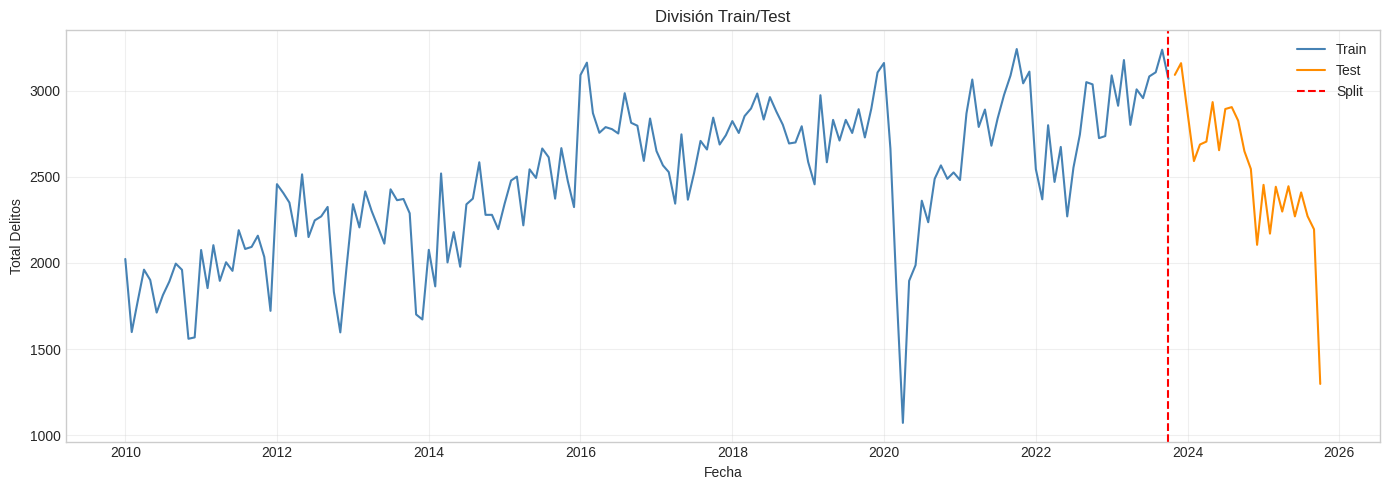

In [14]:
# 4.2 División temporal de datos (train/test)
print("=" * 60)
print("DIVISIÓN TEMPORAL DE DATOS")
print("=" * 60)

# Usar los últimos 24 meses para test
TEST_MONTHS = 24
split_date = df_prophet['ds'].max() - pd.DateOffset(months=TEST_MONTHS)

train = df_prophet[df_prophet['ds'] <= split_date].copy()
test = df_prophet[df_prophet['ds'] > split_date].copy()

print(f"\n✅ División temporal:")
print(f"   Train: {len(train)} meses ({train['ds'].min().strftime('%Y-%m')} a {train['ds'].max().strftime('%Y-%m')})")
print(f"   Test: {len(test)} meses ({test['ds'].min().strftime('%Y-%m')} a {test['ds'].max().strftime('%Y-%m')})")

# Visualizar división
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train['ds'], train['y'], label='Train', color='steelblue')
ax.plot(test['ds'], test['y'], label='Test', color='darkorange')
ax.axvline(split_date, color='red', linestyle='--', label='Split')
ax.set_xlabel('Fecha')
ax.set_ylabel('Total Delitos')
ax.set_title('División Train/Test')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. Modelado con Prophet

In [16]:
# 5.1 Entrenar modelo Prophet
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ENTRENAMIENTO DE MODELO PROPHET")
print("=" * 60)

# Crear y entrenar modelo Prophet
model = Prophet(
    yearly_seasonality=True,      # Estacionalidad anual
    weekly_seasonality=False,     # No hay datos semanales
    daily_seasonality=False,      # No hay datos diarios
    seasonality_mode='additive',  # Estacionalidad aditiva
    changepoint_prior_scale=0.05  # Flexibilidad de la tendencia
)

print("\n Entrenando modelo...")
model.fit(train)
print(" Modelo entrenado")

# Crear dataframe para predicción (incluyendo período de test)
future = model.make_future_dataframe(periods=len(test), freq='MS')
print(f"\n Período de predicción: {future['ds'].min().strftime('%Y-%m')} a {future['ds'].max().strftime('%Y-%m')}")

/home/byverbel/.pyenv/versions/datos_al_ecosistema/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing


ENTRENAMIENTO DE MODELO PROPHET

 Entrenando modelo...
 Modelo entrenado

 Período de predicción: 2010-01 a 2025-10


PREDICCIONES DEL MODELO


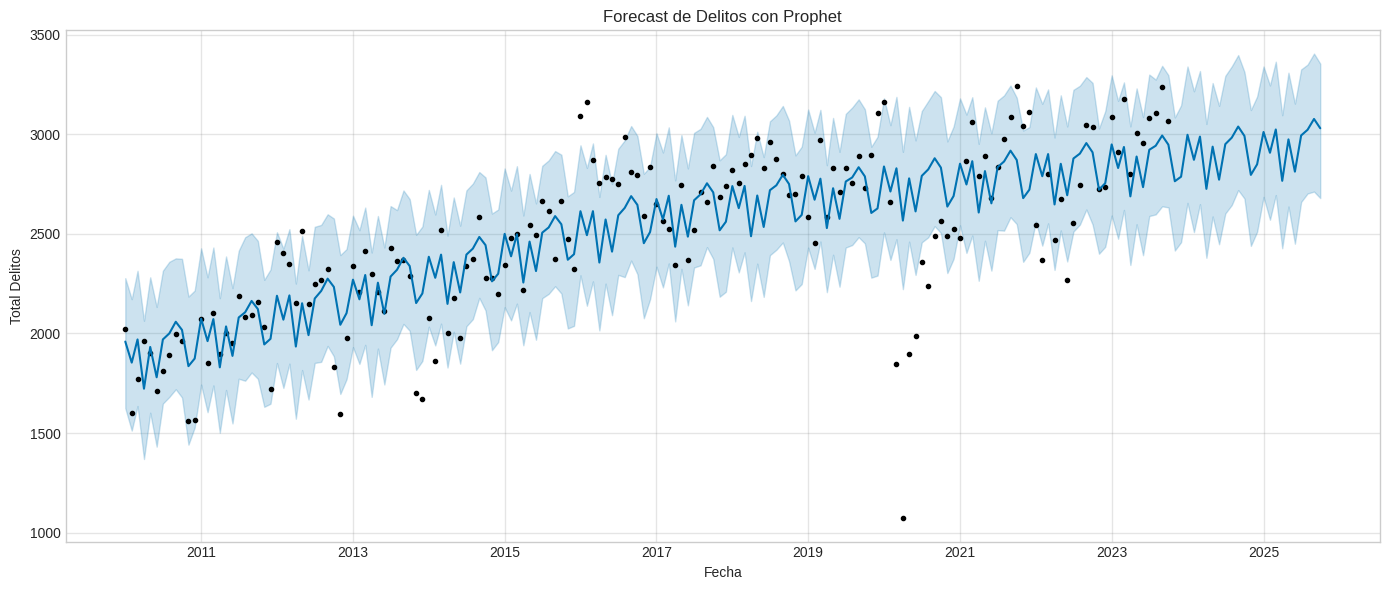

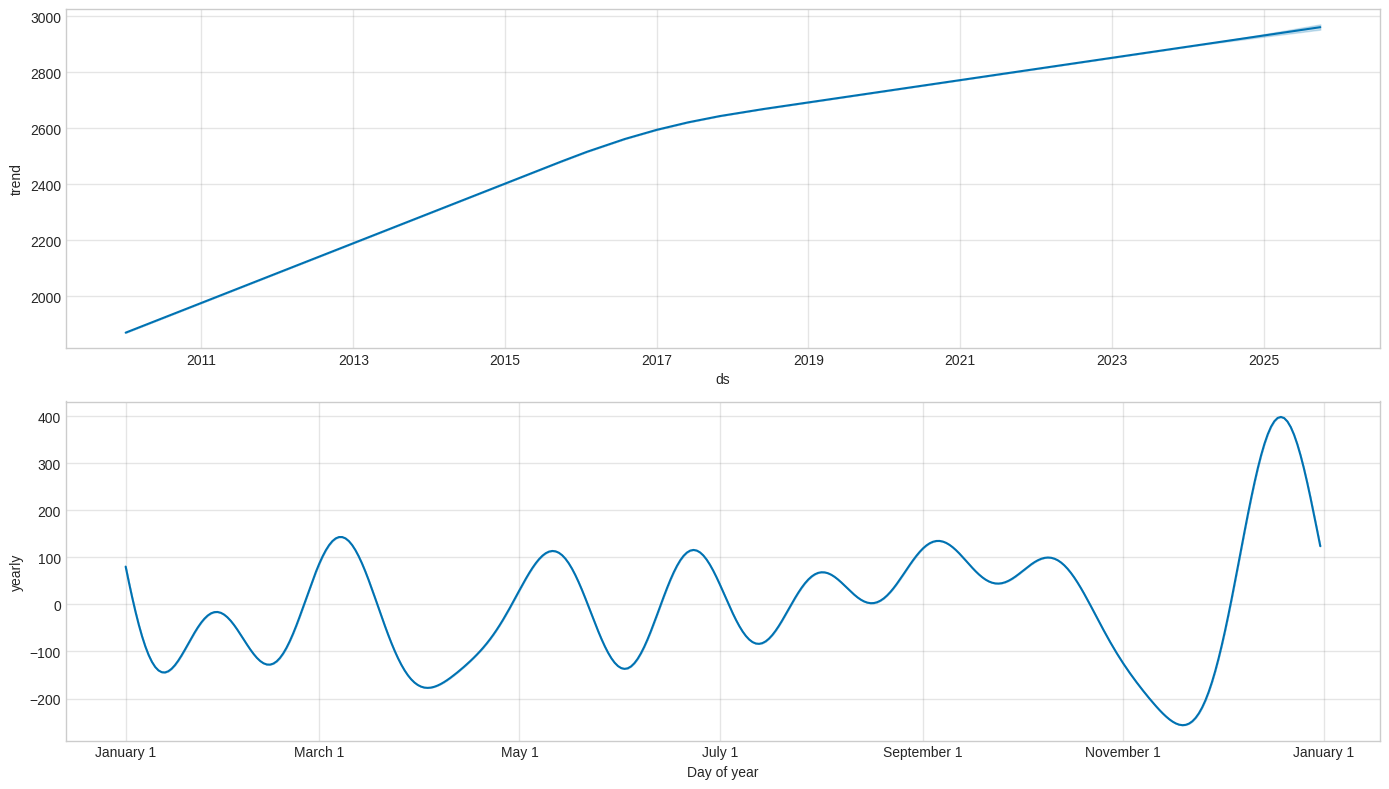

In [17]:
# 5.2 Generar predicciones
print("=" * 60)
print("PREDICCIONES DEL MODELO")
print("=" * 60)

# Predicciones
forecast = model.predict(future)

# Visualización del forecast
fig1 = model.plot(forecast, figsize=(14, 6))
plt.title('Forecast de Delitos con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Total Delitos')
plt.tight_layout()
plt.show()

# Componentes del modelo
fig2 = model.plot_components(forecast, figsize=(14, 8))
plt.tight_layout()
plt.show()

---
## 6. Evaluación del Modelo

EVALUACIÓN DEL MODELO EN TEST

 Métricas de Evaluación:
   MAE:  442.06 delitos
   RMSE: 574.09 delitos
   R²:   -1.1964
   MAPE: 20.93%


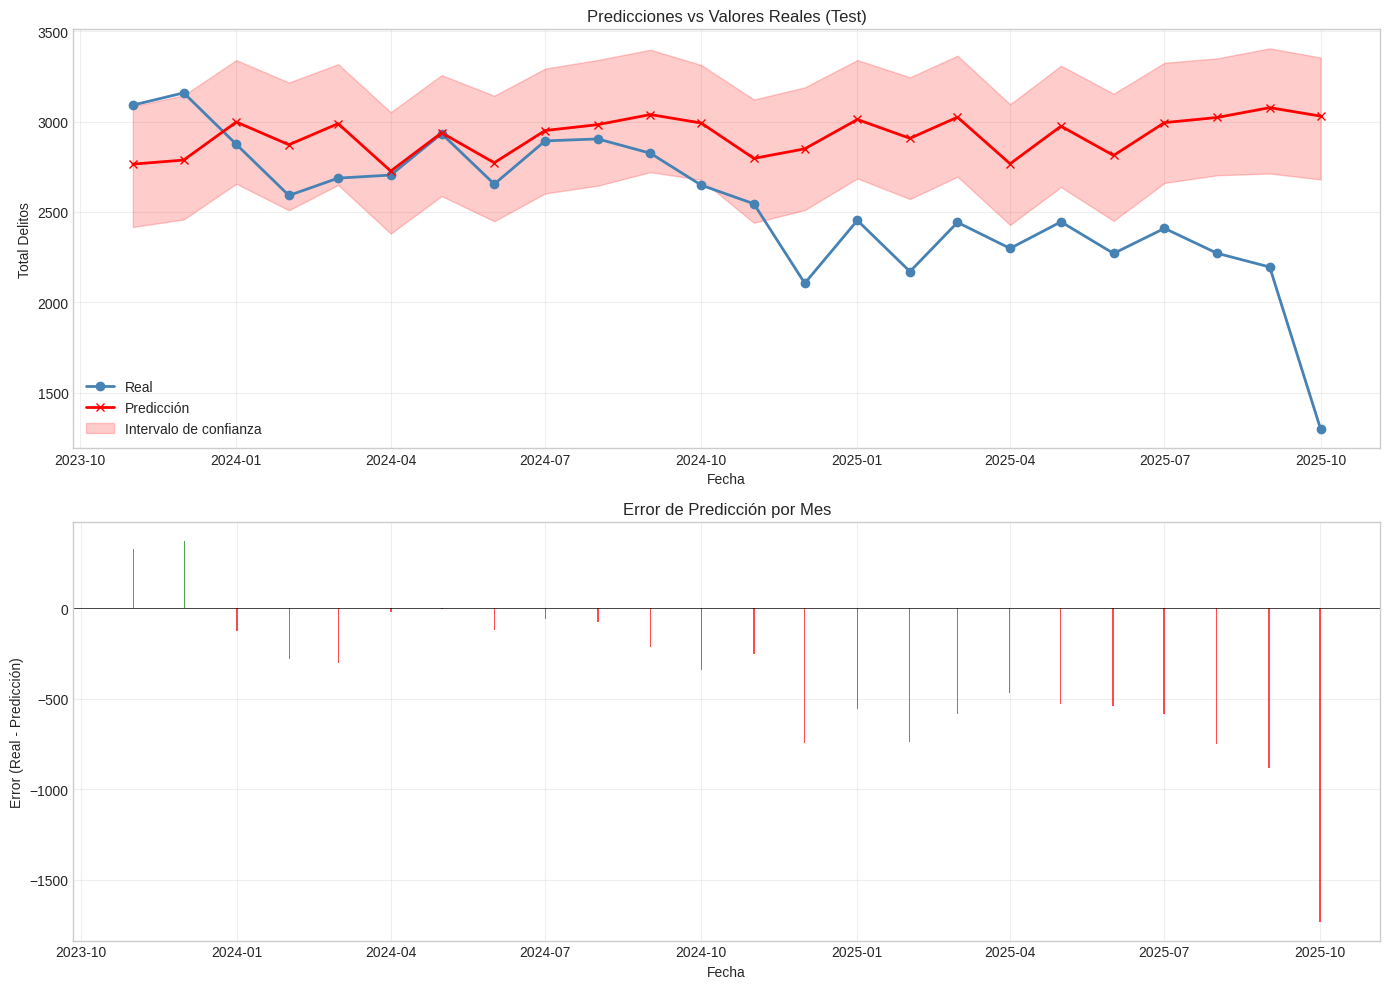

In [18]:
# 6.1 Evaluación en el conjunto de test
print("=" * 60)
print("EVALUACIÓN DEL MODELO EN TEST")
print("=" * 60)

# Obtener predicciones para el período de test
forecast_test = forecast[forecast['ds'] > split_date].copy()
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

# Métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\n Métricas de Evaluación:")
print(f"   MAE:  {mae:.2f} delitos")
print(f"   RMSE: {rmse:.2f} delitos")
print(f"   R²:   {r2:.4f}")
print(f"   MAPE: {mape:.2f}%")

# Visualización de predicciones vs reales
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Predicciones vs Reales
ax1 = axes[0]
ax1.plot(test['ds'], y_true, label='Real', color='steelblue', linewidth=2, marker='o')
ax1.plot(forecast_test['ds'], y_pred, label='Predicción', color='red', linewidth=2, marker='x')
ax1.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], 
                  alpha=0.2, color='red', label='Intervalo de confianza')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Total Delitos')
ax1.set_title('Predicciones vs Valores Reales (Test)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error por mes
ax2 = axes[1]
errores = y_true - y_pred
colors = ['green' if e > 0 else 'red' for e in errores]
ax2.bar(test['ds'], errores, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Error (Real - Predicción)')
ax2.set_title('Error de Predicción por Mes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Optimización de Hiperparámetros

In [19]:
# 7.1 Grid Search para optimizar hiperparámetros de Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

print("=" * 60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# Definir espacio de búsqueda
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generar todas las combinaciones
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"\n Probando {len(all_params)} combinaciones de hiperparámetros...")

# Evaluar cada combinación
results = []
for i, params in enumerate(all_params):
    if i % 8 == 0:
        print(f"   Progreso: {i}/{len(all_params)}...")
    
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        **params
    )
    m.fit(train)
    
    # Predicción en test
    future_test = m.make_future_dataframe(periods=len(test), freq='MS')
    forecast_test = m.predict(future_test)
    forecast_test = forecast_test[forecast_test['ds'] > split_date]
    
    # Calcular MAE
    mae = mean_absolute_error(test['y'], forecast_test['yhat'])
    results.append({**params, 'mae': mae})

# Encontrar mejores parámetros
results_df = pd.DataFrame(results)
best_idx = results_df['mae'].idxmin()
best_params = results_df.iloc[best_idx]

print(f"\n Mejores hiperparámetros encontrados:")
print(f"   changepoint_prior_scale: {best_params['changepoint_prior_scale']}")
print(f"   seasonality_prior_scale: {best_params['seasonality_prior_scale']}")
print(f"   seasonality_mode: {best_params['seasonality_mode']}")
print(f"   MAE: {best_params['mae']:.2f}")

20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing


OPTIMIZACIÓN DE HIPERPARÁMETROS

 Probando 32 combinaciones de hiperparámetros...
   Progreso: 0/32...


20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] 

   Progreso: 8/32...


20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] 

   Progreso: 16/32...


20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1]

   Progreso: 24/32...


20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1]


 Mejores hiperparámetros encontrados:
   changepoint_prior_scale: 0.05
   seasonality_prior_scale: 0.01
   seasonality_mode: additive
   MAE: 441.20


20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing


MODELO OPTIMIZADO

 Comparación Base vs Optimizado:
   Métrica    Base         Optimizado   Mejora    
   --------------------------------------------
   MAE        724.21       441.20       283.01
   RMSE       574.09       571.13       2.96
   R²         -1.1964      -1.1738      0.0226
   MAPE       20.93       % 20.91       % 0.01%


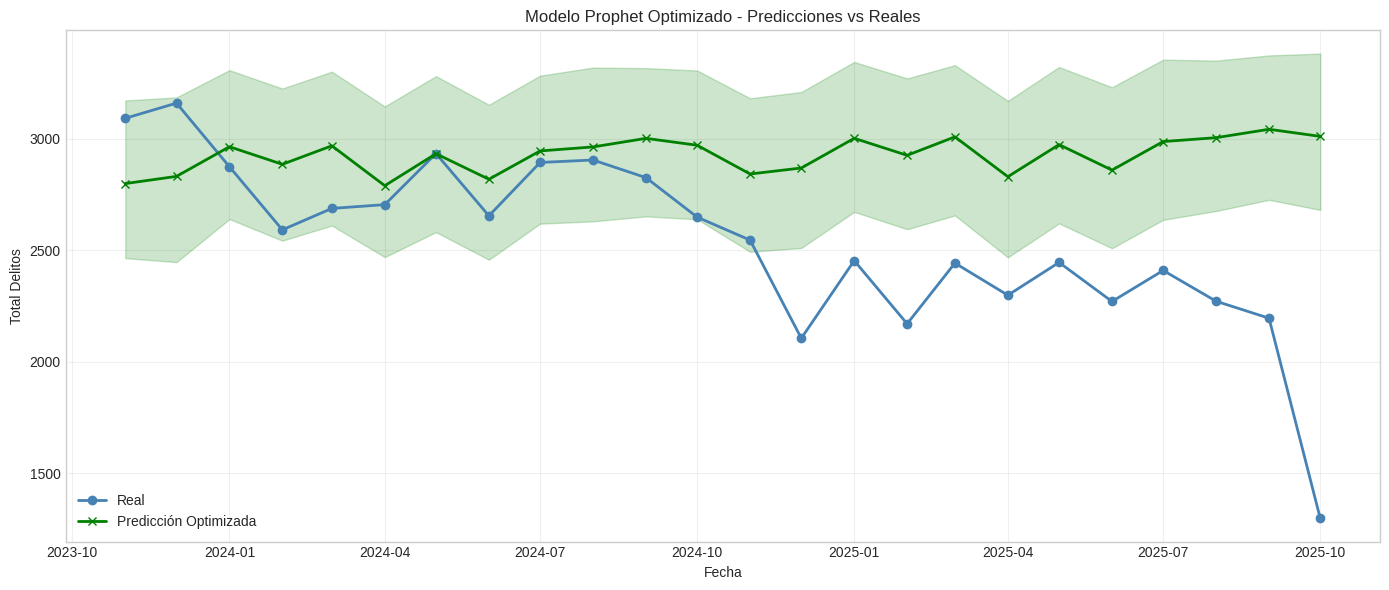

In [20]:
# 7.2 Entrenar modelo optimizado
print("=" * 60)
print("MODELO OPTIMIZADO")
print("=" * 60)

# Crear modelo con mejores parámetros
model_opt = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Entrenar con todos los datos de train
model_opt.fit(train)

# Predicción
future_opt = model_opt.make_future_dataframe(periods=len(test), freq='MS')
forecast_opt = model_opt.predict(future_opt)
forecast_test_opt = forecast_opt[forecast_opt['ds'] > split_date]

# Métricas del modelo optimizado
y_pred_opt = forecast_test_opt['yhat'].values
mae_opt = mean_absolute_error(y_true, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_true, y_pred_opt))
r2_opt = r2_score(y_true, y_pred_opt)
mape_opt = np.mean(np.abs((y_true - y_pred_opt) / y_true)) * 100

print(f"\n Comparación Base vs Optimizado:")
print(f"   {'Métrica':<10} {'Base':<12} {'Optimizado':<12} {'Mejora':<10}")
print(f"   {'-'*44}")
print(f"   {'MAE':<10} {mae:<12.2f} {mae_opt:<12.2f} {(mae-mae_opt):.2f}")
print(f"   {'RMSE':<10} {rmse:<12.2f} {rmse_opt:<12.2f} {(rmse-rmse_opt):.2f}")
print(f"   {'R²':<10} {r2:<12.4f} {r2_opt:<12.4f} {(r2_opt-r2):.4f}")
print(f"   {'MAPE':<10} {mape:<12.2f}% {mape_opt:<12.2f}% {(mape-mape_opt):.2f}%")

# Visualización
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test['ds'], y_true, label='Real', color='steelblue', linewidth=2, marker='o')
ax.plot(forecast_test_opt['ds'], y_pred_opt, label='Predicción Optimizada', color='green', linewidth=2, marker='x')
ax.fill_between(forecast_test_opt['ds'], forecast_test_opt['yhat_lower'], forecast_test_opt['yhat_upper'], 
                alpha=0.2, color='green')
ax.set_xlabel('Fecha')
ax.set_ylabel('Total Delitos')
ax.set_title('Modelo Prophet Optimizado - Predicciones vs Reales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Modelo Final y Forecast Futuro

In [21]:
# 8.1 Entrenar modelo final con TODOS los datos
print("=" * 60)
print("MODELO FINAL CON TODOS LOS DATOS")
print("=" * 60)

# Entrenar modelo final con todos los datos
model_final = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

model_final.fit(df_prophet)
print(" Modelo final entrenado con todos los datos")

# Generar forecast para los próximos 12 meses
FORECAST_MONTHS = 12
future_final = model_final.make_future_dataframe(periods=FORECAST_MONTHS, freq='MS')
forecast_final = model_final.predict(future_final)

# Extraer solo las predicciones futuras
forecast_futuro = forecast_final[forecast_final['ds'] > df_prophet['ds'].max()].copy()

print(f"\n Forecast para los próximos {FORECAST_MONTHS} meses:")
print(forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))

MODELO FINAL CON TODOS LOS DATOS


20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing


 Modelo final entrenado con todos los datos

 Forecast para los próximos 12 meses:
        ds        yhat  yhat_lower  yhat_upper
2025-11-01 2619.938906 2259.375371 3021.177653
2025-12-01 2625.280495 2262.169628 3001.601833
2026-01-01 2738.059214 2361.030587 3128.356138
2026-02-01 2644.312810 2261.986553 3066.219896
2026-03-01 2726.968669 2368.311594 3113.800719
2026-04-01 2565.600747 2206.338165 2935.159037
2026-05-01 2702.586870 2294.562547 3066.401320
2026-06-01 2582.821548 2207.042773 2960.125185
2026-07-01 2707.258010 2326.522805 3103.155922
2026-08-01 2713.356231 2353.965459 3096.382254
2026-09-01 2735.852227 2356.153808 3112.069155
2026-10-01 2659.150760 2277.903132 3005.167738


VISUALIZACIÓN DEL FORECAST FUTURO


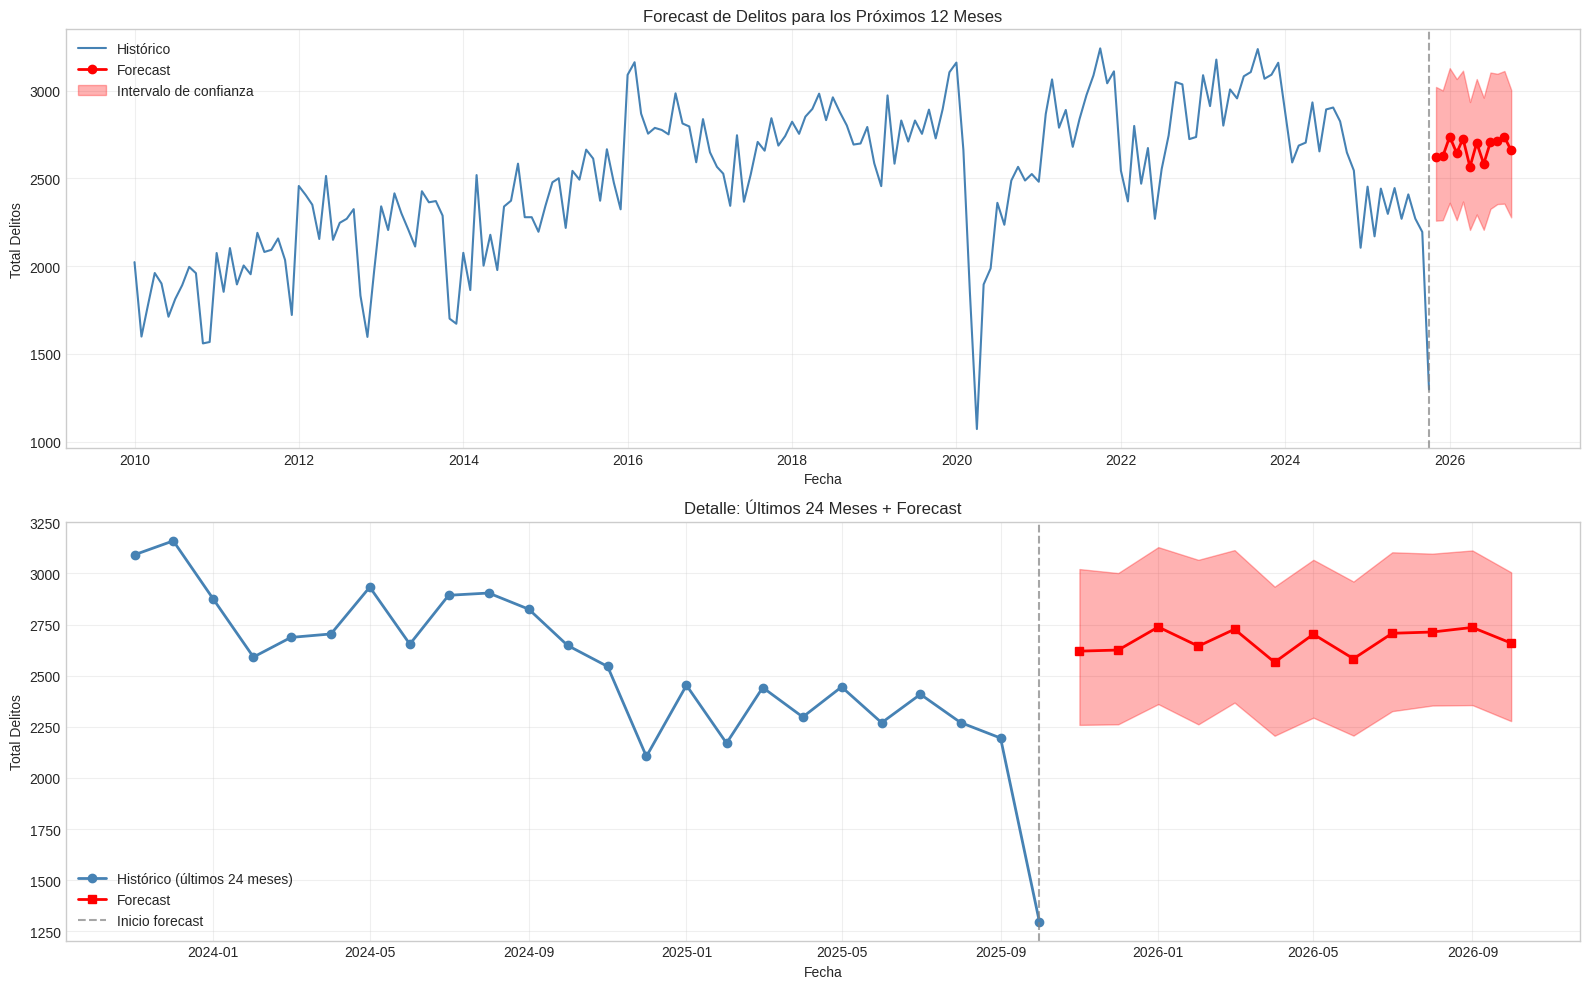


 Resumen del Forecast:
   Promedio predicho: 2668 delitos/mes
   Mínimo predicho: 2566 delitos/mes
   Máximo predicho: 2738 delitos/mes


In [22]:
# 8.2 Visualización del forecast futuro
print("=" * 60)
print("VISUALIZACIÓN DEL FORECAST FUTURO")
print("=" * 60)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Serie completa + forecast
ax1 = axes[0]
ax1.plot(df_prophet['ds'], df_prophet['y'], label='Histórico', color='steelblue', linewidth=1.5)
ax1.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label='Forecast', color='red', linewidth=2, marker='o')
ax1.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], 
                  alpha=0.3, color='red', label='Intervalo de confianza')
ax1.axvline(df_prophet['ds'].max(), color='gray', linestyle='--', alpha=0.7)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Total Delitos')
ax1.set_title('Forecast de Delitos para los Próximos 12 Meses')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom en el forecast
ax2 = axes[1]
# Últimos 24 meses + forecast
ultimos_24 = df_prophet.tail(24)
ax2.plot(ultimos_24['ds'], ultimos_24['y'], label='Histórico (últimos 24 meses)', color='steelblue', linewidth=2, marker='o')
ax2.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label='Forecast', color='red', linewidth=2, marker='s')
ax2.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], 
                  alpha=0.3, color='red')
ax2.axvline(df_prophet['ds'].max(), color='gray', linestyle='--', alpha=0.7, label='Inicio forecast')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Total Delitos')
ax2.set_title('Detalle: Últimos 24 Meses + Forecast')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen del forecast
print("\n Resumen del Forecast:")
print(f"   Promedio predicho: {forecast_futuro['yhat'].mean():.0f} delitos/mes")
print(f"   Mínimo predicho: {forecast_futuro['yhat'].min():.0f} delitos/mes")
print(f"   Máximo predicho: {forecast_futuro['yhat'].max():.0f} delitos/mes")

---
## 9. Guardado del Modelo

In [25]:
# 9.1 Guardar modelo y artefactos
import joblib
import json

# Crear directorio
MODEL_NAME = 'regression_timeseries'
MODELS_DIR = BASE_DIR / 'models' / 'timeserie' / MODEL_NAME
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Guardar modelo Prophet (serialización con joblib)
joblib.dump(model_final, MODELS_DIR / 'prophet_model.joblib')

# Guardar forecast futuro como CSV
forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(
    MODELS_DIR / 'forecast_futuro.csv', index=False
)

# Guardar metadata
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'Prophet',
    'created_at': pd.Timestamp.now().isoformat(),
    'training_data': {
        'start': df_prophet['ds'].min().isoformat(),
        'end': df_prophet['ds'].max().isoformat(),
        'n_months': len(df_prophet)
    },
    'best_params': {
        'changepoint_prior_scale': float(best_params['changepoint_prior_scale']),
        'seasonality_prior_scale': float(best_params['seasonality_prior_scale']),
        'seasonality_mode': best_params['seasonality_mode']
    },
    'metrics': {
        'MAE': float(mae_opt),
        'RMSE': float(rmse_opt),
        'R2': float(r2_opt),
        'MAPE': float(mape_opt)
    },
    'forecast': {
        'months': FORECAST_MONTHS,
        'start': forecast_futuro['ds'].min().isoformat(),
        'end': forecast_futuro['ds'].max().isoformat(),
        'mean_prediction': float(forecast_futuro['yhat'].mean())
    }
}

with open(MODELS_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f" Modelo guardado en: {MODELS_DIR}")
print(f"\n Archivos guardados:")
for file in sorted(MODELS_DIR.iterdir()):
    print(f"   - {file.name}")

 Modelo guardado en: /home/byverbel/challenges/Datos-al-Ecosistema/models/timeserie/regression_timeseries

 Archivos guardados:
   - forecast_futuro.csv
   - metadata.json
   - prophet_model.joblib


---
## 10. Ejemplo de Uso y Conclusiones

In [24]:
# 10.1 Ejemplo de uso del modelo
print("=" * 60)
print("EJEMPLO DE USO DEL MODELO")
print("=" * 60)

# Simular carga del modelo
modelo_cargado = joblib.load(MODELS_DIR / 'prophet_model.joblib')

# Generar forecast para un nuevo período
nuevo_forecast = modelo_cargado.make_future_dataframe(periods=6, freq='MS')
predicciones = modelo_cargado.predict(nuevo_forecast)

# Mostrar últimas predicciones
ultimas = predicciones.tail(6)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("\n Predicciones para los próximos 6 meses:")
for _, row in ultimas.iterrows():
    print(f"   {row['ds'].strftime('%Y-%m')}: {row['yhat']:.0f} delitos (IC: {row['yhat_lower']:.0f} - {row['yhat_upper']:.0f})")

EJEMPLO DE USO DEL MODELO

 Predicciones para los próximos 6 meses:
   2025-11: 2620 delitos (IC: 2223 - 2987)
   2025-12: 2625 delitos (IC: 2258 - 3009)
   2026-01: 2738 delitos (IC: 2365 - 3114)
   2026-02: 2644 delitos (IC: 2262 - 2997)
   2026-03: 2727 delitos (IC: 2348 - 3106)
   2026-04: 2566 delitos (IC: 2189 - 2947)
